In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [2]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt

import pickle

from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#### Preparing data
data_dict = pickle.load(open('model_data_dictionary_N_Pa.pkl', 'rb'))


# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

print("After grouping all data together, relevant shapes are:")
print(f"us : {us.shape}")
print(f"ys : {ys.shape}")
print(f"fs : {fs.shape}")
print(f"ws : {ws.shape}")

In total there are 22 distinct membranes.
After grouping all data together, relevant shapes are:
us : (188318, 7)
ys : (188318, 1)
fs : (188318, 1)
ws : (188318, 1)


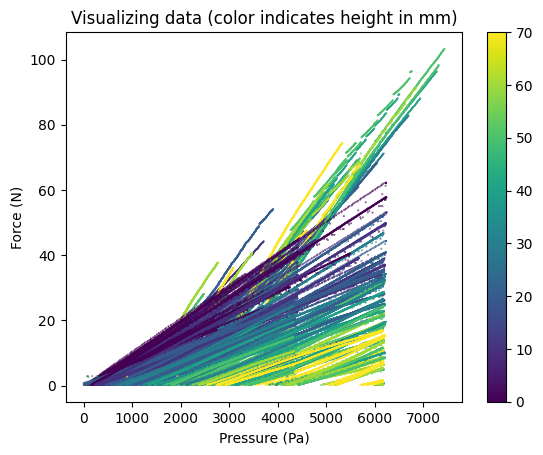

In [4]:
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

## Training Model from Data

In [5]:
%autoreload 2
from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

In [6]:
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [7]:
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))

# Define ensemble
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model
print(model.tabulate())

Initializing model...

                                             RPNEnsemble Summary                                              
┌──────────────────────┬───────────────────┬────────────────────┬─────────────────────┬──────────────────────┐
│ path                 │ module            │ inputs             │ outputs             │ params               │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│                      │ RPNEnsemble       │ - float32[10000,7] │ float32[32,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │                      │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble  │ - float32[10000,7] │ float32[64,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │  

In [8]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [36:01<00:00,  4.63it/s, loss=2.2258208, grad_norm=0.45212469] 


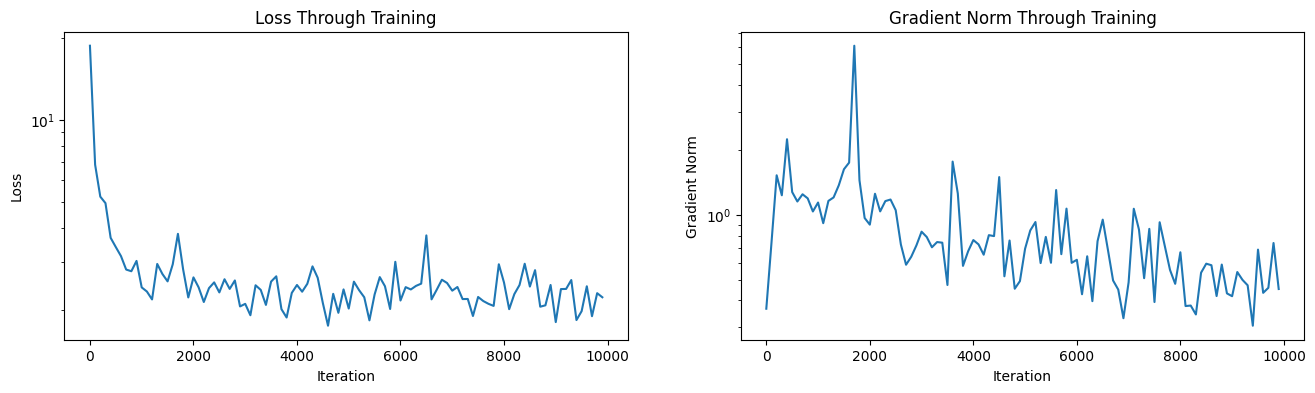

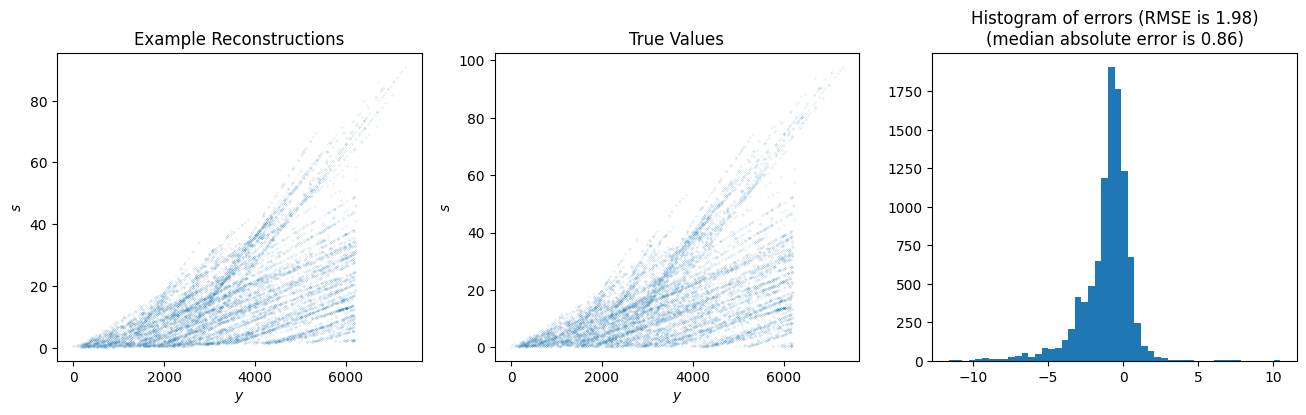

In [9]:
model.plot_training_log()
model.plot_predictions(init_batch)

## Membrane Design Optimization

In [10]:
%autoreload 2
from acquisition import MCAcquisition
from design_optimization import get_trajectory_posterior_fn, get_height_max_posterior_fn
from design_optimization import opt_var_to_phys_var, print_recommendations

In [11]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([14.7, 24.5, 39.24])
target_Ps = jnp.array([6895, 6895, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [12]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


100%|██████████| 5000/5000 [08:16<00:00, 10.07it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [13:50<00:00,  6.02it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [12:44<00:00,  6.54it/s]


In [13]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  32.00
Ring 1) radius:  46.76; width:  5.00
Ring 2) radius:  59.76; width:  5.00


In [14]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -2.99e+02):
Forces obtained are: [28.248684 33.8134   42.158688]
Pressures obtained are: [4308.3027 5119.892  6337.016 ]
Heights obtained are: [0. 0. 0.]

Membrane:
thickness:  2.51
contact radius:  25.40

------------------

Using 1 rings (acquisition score is  3.82e-01):
Forces obtained are: [14.697633 24.49626  39.22719 ]
Pressures obtained are: [6895.244  6895.566  6897.6836]
Heights obtained are: [59.688793 49.01965  32.94192 ]

Membrane:
thickness:  2.00
contact radius:  32.65
Ring 1) radius:  44.66; width:  5.00

------------------

Using 2 rings (acquisition score is  4.32e-01):
Forces obtained are: [14.693799 24.49075  39.238426]
Pressures obtained are: [6892.729  6894.2354 6892.099 ]
Heights obtained are: [61.862717 52.7832   36.62507 ]

Membrane:
thickness:  2.00
contact radius:  32.00
Ring 1) radius:  46.76; width:  5.00
Ring 2) radius:  59.76; width:  5.00


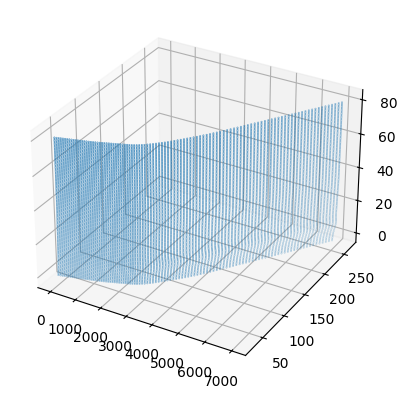

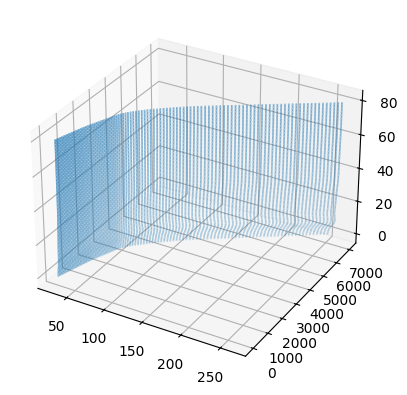

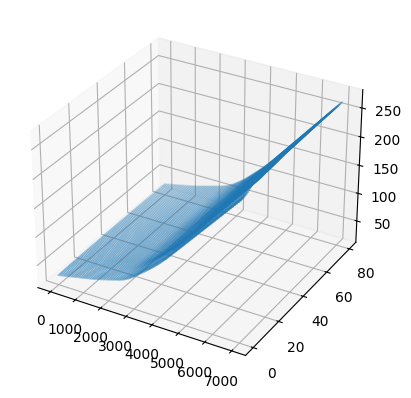

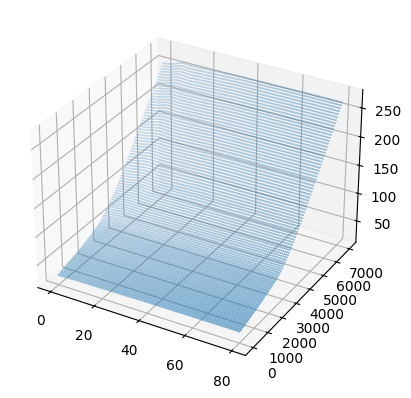

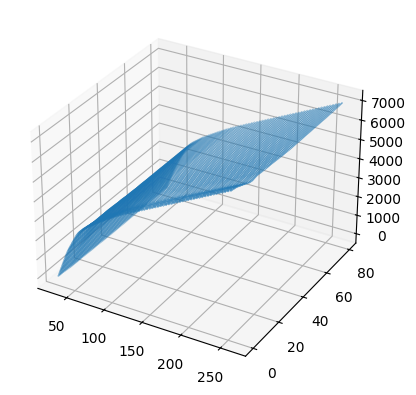

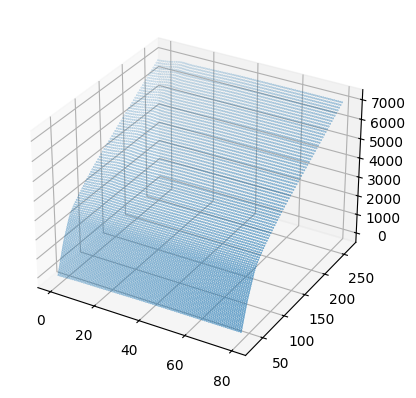

In [15]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()

In [16]:
jnp.isnan(model.apply(model.params, us, ys)).mean()*32

Array(0., dtype=float32)

#### New Optimization

In [17]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([24.5, 24.5, 24.5])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [18]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


100%|██████████| 5000/5000 [09:27<00:00,  8.80it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [12:42<00:00,  6.56it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [08:26<00:00,  9.87it/s]


In [19]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  38.10
Ring 1) radius:  46.47; width:  5.00
Ring 2) radius:  59.47; width:  5.00


In [20]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -1.23e+02):
Forces obtained are: [25.552822 29.74076  33.815125]
Pressures obtained are: [3917.2876 4525.8354 5120.1875]
Heights obtained are: [3.139343 0.       0.      ]

Membrane:
thickness:  2.50
contact radius:  25.40

------------------

Using 1 rings (acquisition score is  2.56e-01):
Forces obtained are: [24.48706  24.497864 24.49727 ]
Pressures obtained are: [4140.512 5517.182 6895.482]
Heights obtained are: [25.667915 38.405544 46.79564 ]

Membrane:
thickness:  2.00
contact radius:  38.10
Ring 1) radius:  46.10; width:  5.00

------------------

Using 2 rings (acquisition score is  2.97e-01):
Forces obtained are: [24.478327 24.508291 24.479677]
Pressures obtained are: [4137.685  5515.028  6895.6797]
Heights obtained are: [28.547121 41.28822  49.518578]

Membrane:
thickness:  2.00
contact radius:  38.10
Ring 1) radius:  46.47; width:  5.00
Ring 2) radius:  59.47;

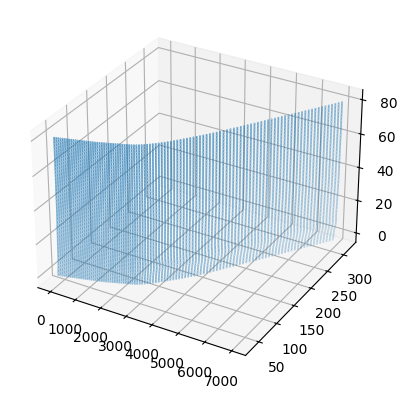

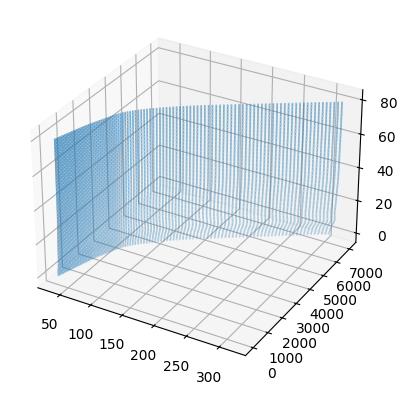

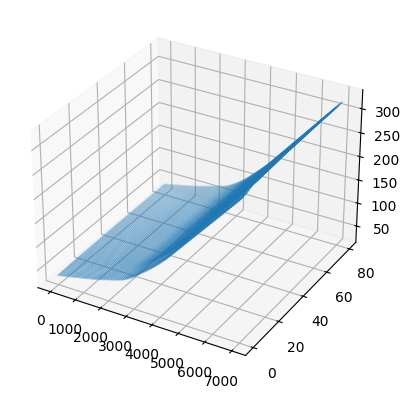

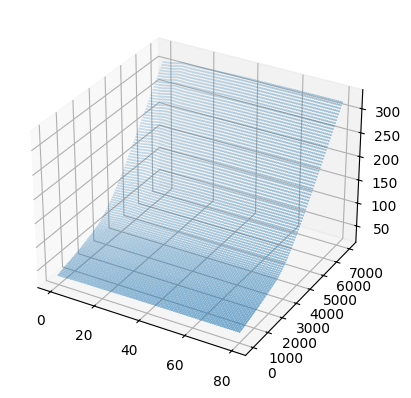

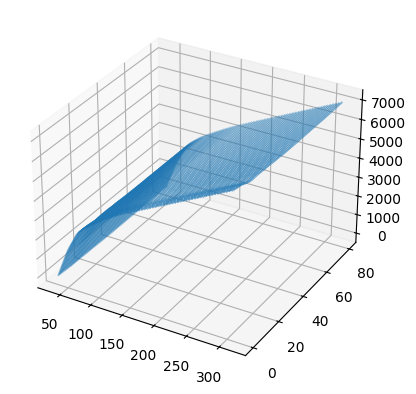

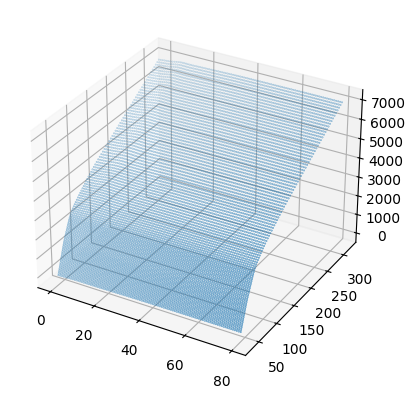

In [21]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()

#### New (new!) Optimization

In [22]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([14.72, 14.72, 14.72])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [23]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 0 rings...


100%|██████████| 5000/5000 [10:39<00:00,  7.82it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [15:29<00:00,  5.38it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [09:12<00:00,  9.05it/s] 


In [24]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  26.02
Ring 1) radius:  46.47; width:  5.00
Ring 2) radius:  59.59; width:  5.00


In [25]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -2.26e+02):
Forces obtained are: [15.700982 18.101759 20.36334 ]
Pressures obtained are: [3636.2007 3766.7087 3886.995 ]
Heights obtained are: [70.      68.6882  69.61204]

Membrane:
thickness:  3.00
contact radius:  38.10

------------------

Using 1 rings (acquisition score is  4.63e-01):
Forces obtained are: [14.698319 14.714097 14.717975]
Pressures obtained are: [4141.0303 5517.03   6895.298 ]
Heights obtained are: [38.104828 55.07887  67.781136]

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  43.38; width:  5.00

------------------

Using 2 rings (acquisition score is  5.05e-01):
Forces obtained are: [14.6986475 14.730213  14.712661 ]
Pressures obtained are: [4138.2417 5513.4727 6885.1577]
Heights obtained are: [41.494804 57.483826 70.      ]

Membrane:
thickness:  2.00
contact radius:  26.02
Ring 1) radius:  46.47; width:  5.00
Ring 2) radius:  

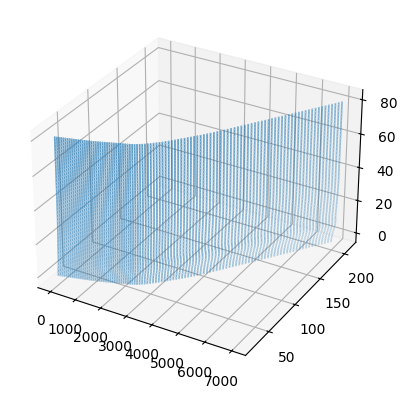

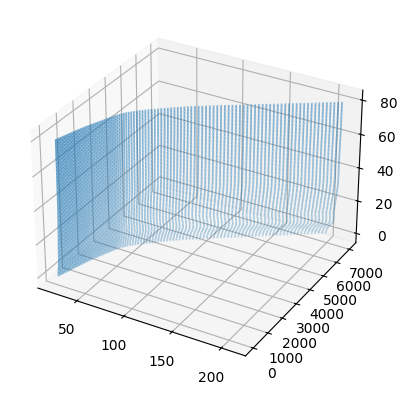

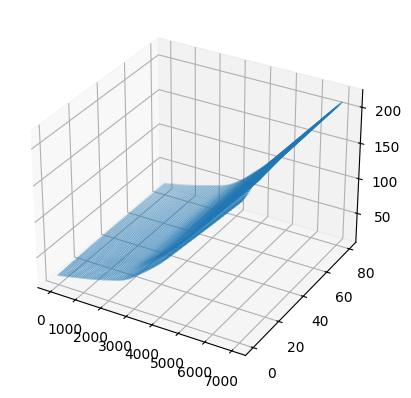

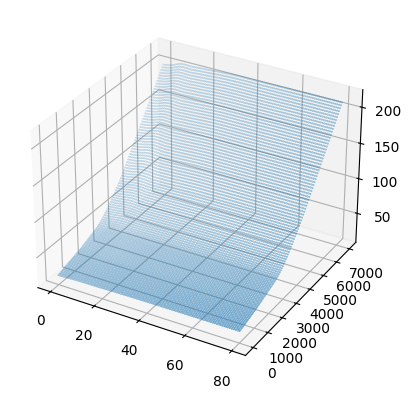

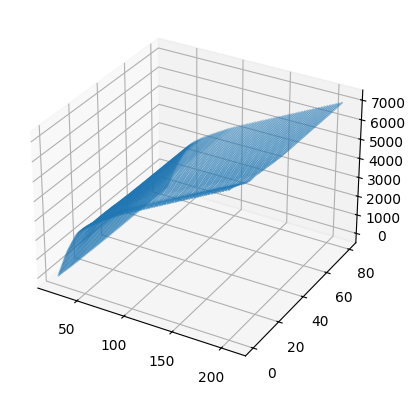

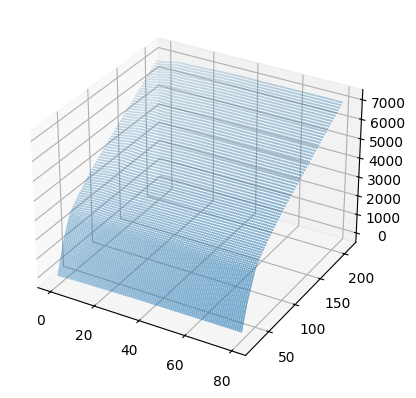

In [26]:
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()

# Even NEWER design optimization (go to high force high pressure)

In [27]:
# Using 2 rings (acquisition score is  7.14e-01):
# Forces obtained are: [39.244083 39.220383 39.22216 ]
# Pressures obtained are: [8277.179 8271.041 8271.795]
# Heights obtained are: [50.08479  50.0486   50.055122]

# Membrane:
# thickness:  2.00
# contact radius:  25.58
# Ring 1) radius:  46.80; width:  5.00
# Ring 2) radius:  59.82; width:  5.00


# With mean height maximization:
# Using 2 rings (acquisition score is  8.50e-01):
# Forces obtained are: [14.703299 24.485249 39.23942 ]
# Pressures obtained are: [8271.504 8274.059 8273.852]
# Heights obtained are: [69.991035 60.41282  48.178787]

# Membrane:
# thickness:  2.00
# contact radius:  31.72
# Ring 1) radius:  48.62; width:  5.00
# Ring 2) radius:  61.90; width:  5.01

In [28]:
# set target Forces and Pressures (they should be the same shape)
# target_Fs = jnp.array([39.24, 39.24, 39.24])
target_Fs = jnp.array([14.7, 24.5, 39.24])
target_Ps = jnp.array([8273, 8273, 8273])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [29]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome


Determining best membranes to test using 0 rings...


100%|██████████| 5000/5000 [07:53<00:00, 10.57it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 5000/5000 [20:54<00:00,  3.99it/s]  


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [09:07<00:00,  9.13it/s]


The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  31.83
Ring 1) radius:  47.28; width:  5.00
Ring 2) radius:  60.35; width:  5.00
Here are the recommendations considering all possibilities.

------------------

Using 0 rings (acquisition score is -5.78e+02):
Forces obtained are: [32.363335 37.978905 46.258835]
Pressures obtained are: [4907.132 5729.489 6941.908]
Heights obtained are: [0. 0. 0.]

Membrane:
thickness:  2.45
contact radius:  25.40

------------------

Using 1 rings (acquisition score is  5.41e-01):
Forces obtained are: [14.704837 24.496197 39.228413]
Pressures obtained are: [8272.082 8273.399 8275.166]
Heights obtained are: [70.       60.011433 44.214024]

Membrane:
thickness:  2.00
contact radius:  30.01
Ring 1) radius:  45.48; width:  5.00

------------------

Using 2 rings (acquisition score is  5.80e-01):
Forces obtained are: [14.710162 24.490227 39.23583 ]
Pressures obtained are: [8274.6875 

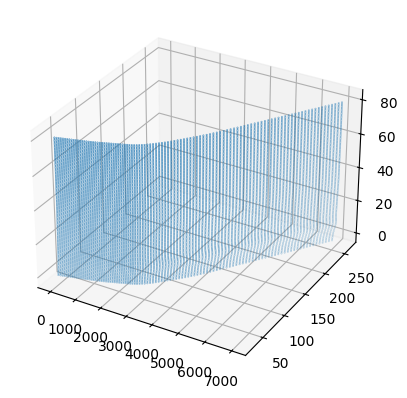

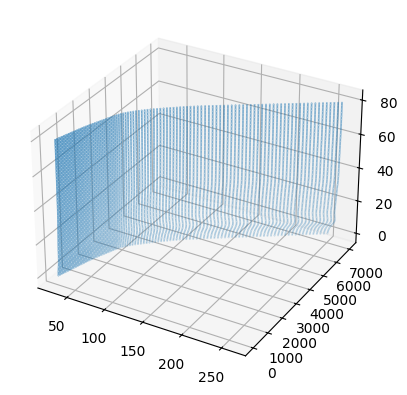

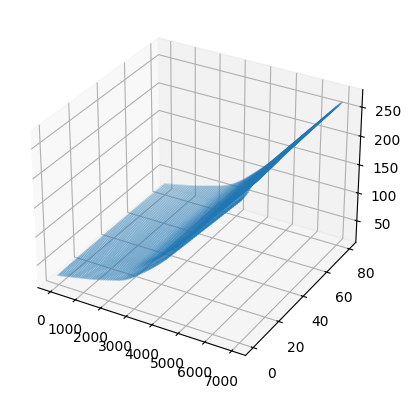

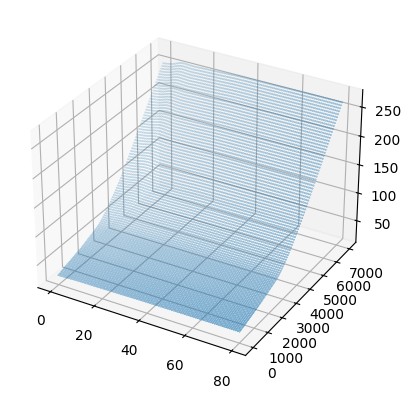

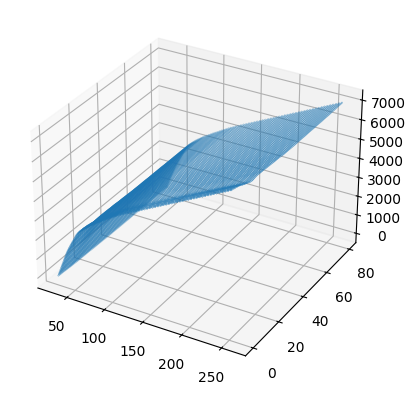

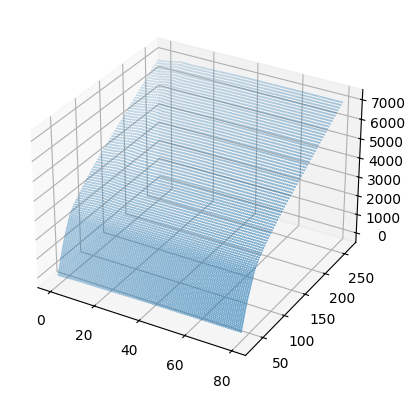

In [30]:
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)
print("Here are the recommendations considering all possibilities.")
for num_rings in [0,1,2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2e}):')
    fs, ps, hs = posterior(recs[num_rings], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[num_rings][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

# viewing this in 3d space using different angles
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, FF, HH, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, PP, HH, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(PP, HH, FF, s=0.1)
plt.show()


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, PP, FF, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(FF, HH, PP, s=0.1)
plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(HH, FF, PP, s=0.1)
plt.show()